## Import Libs

In [1]:
# Imports EDA
import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

# Imports Learning
from  sklearn.model_selection import cross_val_predict, cross_validate, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Otimização de Hiperparâmetros
import optuna

## Carregamento Datasets

In [2]:
# Carregar Dataset
df_segmento = pd.read_csv('./datasets/dataset.csv')

## EDA

In [3]:
# Visualizar os dados
df_segmento.head(10)

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao,segmento_de_cliente
0,Comércio,713109.95,12,Rio de Janeiro,6,1,Bronze
1,Comércio,790714.38,9,São Paulo,15,0,Bronze
2,Comércio,1197239.33,17,São Paulo,4,9,Silver
3,Indústria,449185.78,15,São Paulo,6,0,Starter
4,Agronegócio,1006373.16,15,São Paulo,15,8,Silver
5,Serviços,1629562.41,16,Rio de Janeiro,11,4,Silver
6,Serviços,771179.95,13,Vitória,0,1,Starter
7,Serviços,707837.61,16,São Paulo,10,6,Silver
8,Comércio,888983.66,17,Belo Horizonte,10,1,Bronze
9,Indústria,1098512.64,13,Rio de Janeiro,9,3,Bronze


In [4]:
# Estrutura do Dataset
df_segmento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
 6   segmento_de_cliente     500 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 27.5+ KB


Não precisamos lidar com dados ausentes nem dados nulos

In [5]:
# Valores possíveis - Variáveis Categóricas
df_segmento['atividade_economica'].unique()

array(['Comércio', 'Indústria', 'Agronegócio', 'Serviços'], dtype=object)

In [6]:
# Valores possíveis - Variáveis Categóricas
df_segmento['localizacao'].unique()

array(['Rio de Janeiro', 'São Paulo', 'Vitória', 'Belo Horizonte'],
      dtype=object)

In [7]:
# Valores possíveis - Variáveis Categóricas
df_segmento['segmento_de_cliente'].unique()

array(['Bronze', 'Silver', 'Starter', 'Gold'], dtype=object)

In [8]:
# Valores possíveis - Variáveis Numericas
df_segmento['inovacao'].unique()

array([1, 0, 9, 8, 4, 6, 3, 7, 5, 2])

In [9]:
# Distribuição da Variável Target (segmento_de_cliente)
contagem_target = df_segmento['segmento_de_cliente'].value_counts()
contagem_target

segmento_de_cliente
Silver     260
Bronze     202
Starter     22
Gold        16
Name: count, dtype: int64

In [10]:
# Criar uma lista ordenada do target
lista_ordenada_target = ['Starter', 'Bronze', 'Silver', 'Gold']

In [11]:
# Distribuição da Variável Target (segmento_de_cliente) - Gráfico
px.bar(
    contagem_target, 
    x=contagem_target.index,
      y=contagem_target.values,
      color=contagem_target.index, 
      title='Distribuição da Variável Target', 
      category_orders={'segmento_de_cliente': lista_ordenada_target}
)

Não temos uniformidade de registros, consideramos uma base desbalanceada. 

In [12]:
# Distribuição da Variável Target (segmento_de_cliente) - Percentual
percentual_target = contagem_target / len(df_segmento) * 100

In [13]:
# Distribuição da Variável Target (segmento_de_cliente) - Gráfico Percentua
px.bar(
    percentual_target, 
    color=percentual_target.index, 
    title='Distribuição da Variável Target (%)', 
    category_orders={'segmento_de_cliente': lista_ordenada_target}
)

In [14]:
# Distribuição da Variável Target (Localização) - Gráfico Percentua
percentual_localizacao = df_segmento.value_counts('localizacao') / len(df_segmento) * 100
px.bar(
    percentual_localizacao, 
    color=percentual_localizacao.index, 
    title='Distribuição da Localização (%)',
)

Registros mais uniformes em relação a localização

In [15]:
# Distribuição da Variável Target (atividade_economica) - Gráfico Percentua
percentual_atividade_economica = df_segmento.value_counts('atividade_economica') / len(df_segmento) * 100
px.bar(
    percentual_atividade_economica, 
    color=percentual_atividade_economica.index, 
    title='Distribuição Categoria Atividade Econômica (%)',
)

In [16]:
# Distribuição da Variável Target (inovacao) - Gráfico Percentua
percentual_inovacao = df_segmento.value_counts('inovacao') / len(df_segmento) * 100
px.bar(
    percentual_inovacao, 
    color=percentual_inovacao.index, 
    title='Distribuição Categoria Inovação (%)',
)

### Tabela de Contingencia

In [17]:
# Tabela de Contingência - Localização x Segmento de Cliente (target)
crosstab_localizacao = pd.crosstab(
    df_segmento['localizacao'],
    df_segmento['segmento_de_cliente'], 
    margins=True)[lista_ordenada_target].reset_index()

tabela_localizacao = ff.create_table(crosstab_localizacao)

#Mostrar a tabela
tabela_localizacao.show()

In [18]:
# Tabela de Contingência - Atividade x Segmento de Cliente (target)
crosstab_atividade = pd.crosstab(
    df_segmento['atividade_economica'],
    df_segmento['segmento_de_cliente'], 
    margins=True)[lista_ordenada_target].reset_index()

tabela_atividade = ff.create_table(crosstab_atividade)

#Mostrar a tabela
tabela_atividade.show()

In [19]:
# Tabela de Contingência - Inovação x Segmento de Cliente (target)
crosstab_inovacao= pd.crosstab(
    df_segmento['inovacao'],
    df_segmento['segmento_de_cliente'], 
    margins=True)[lista_ordenada_target].reset_index()

tabela_inovacao = ff.create_table(crosstab_inovacao)

#Mostrar a tabela
tabela_inovacao.show()

### Variaveis numericas

In [21]:
# Distribuição Idade da empresa
px.histogram(
    df_segmento, 
    x='idade', 
    title='Distribuição Idade da Empresa'
)

A idade parece seguir uma distribuição normal

In [23]:
# Distribuição Idade da empresa
px.histogram(
    df_segmento, 
    x='faturamento_mensal', 
    title='Distribuição Faturamento Mensal'
)

Formato parecido com sino, parece seguir distribuição normal

In [26]:
# BoxPlot entre idade e segmento
px.box(
    df_segmento, 
    x='segmento_de_cliente', 
    y='idade', 
    title='BoxPlot Idade x Segmento de Cliente',
    color='segmento_de_cliente',
    category_orders={'segmento_de_cliente': lista_ordenada_target}
)

É possivel notar que a medida que as empresas são mais velhas, as medianas das categorias tambem aumentam. alguns outliers no starter . A idade parece afetar mas não tanto o segmento

In [27]:
# BoxPlot entre faturamento e segmento
px.box(
    df_segmento, 
    x='segmento_de_cliente', 
    y='faturamento_mensal', 
    title='BoxPlot Faturamento Mensal x Segmento de Cliente',
    color='segmento_de_cliente',
    category_orders={'segmento_de_cliente': lista_ordenada_target}
)

Também nao parece ter relaçao, existem empresas bronze faturando mais que o maximo de empresas gold. 

### Correlação de Variaveis Qualitativas

In [29]:
# Teste de Qui-Quadrado de Pearson
# H0 - as váriaveis são independentes
# H1 - as váriaveis não são independentes
# p-value inferior a 0,05 rejeita-se a hipótese nula (H0)
# p-value superior a 0,05 não rejeita-se a hipótese nula (H0)

valor_esperado, valor_observado, estatisticas = pg.chi2_independence(df_segmento, x='localizacao', y='segmento_de_cliente')

/home/tauan/.local/share/virtualenvs/classificacao_arvore_decisao-vV22FHe3/lib/python3.12/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on observed frequencies.

/home/tauan/.local/share/virtualenvs/classificacao_arvore_decisao-vV22FHe3/lib/python3.12/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on expected frequencies.



In [30]:
# Valor esperado é a frequência esperada se não houvesse relação entre as variáveis.
# É calculado utilizando a distribuição assumida no teste qui-quadrado.
valor_esperado

segmento_de_cliente,Bronze,Gold,Silver,Starter
localizacao,,,,
Belo Horizonte,44.844,3.552,57.72,4.884
Rio de Janeiro,52.924,4.192,68.12,5.764
São Paulo,48.884,3.872,62.92,5.324
Vitória,55.348,4.384,71.24,6.028


In [31]:
# Valor observado é a frequência observada na amostra (real).
valor_observado

segmento_de_cliente,Bronze,Gold,Silver,Starter
localizacao,,,,
Belo Horizonte,39,4,63,5
Rio de Janeiro,62,3,60,6
São Paulo,45,5,65,6
Vitória,56,4,72,5


In [32]:
# Estatisticas do teste
estatisticas.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,5.19335,9.0,0.81714,0.05884,0.11369
1,cressie-read,0.66667,5.19198,9.0,0.81726,0.05883,0.11367
2,log-likelihood,0.00000,5.19713,9.0,0.81680,0.05886,0.11374
3,freeman-tukey,-0.50000,5.20798,9.0,0.81581,0.05892,0.11390
4,mod-log-likelihood,-1.00000,5.22494,9.0,0.81428,0.05902,0.11414
5,neyman,-2.00000,5.27777,9.0,0.80945,0.05932,0.11490


pval é maior que 0,05, aceitamos a hipotese nula H0, as variaveis são independentes (segmento_de_cliente e localização)

## Treinamento Modelo Classificação

In [33]:
# Separar X e y
X = df_segmento.drop('segmento_de_cliente', axis=1)
y = df_segmento['segmento_de_cliente']

In [37]:
# Pipeline de Pré-Processamento
# SimpleImputer - Imputar valores ausentes
# OneHotEncoder - Variáveis Categóricas
# Treinamento Modelo

# Lista de variáveis categóricas
variaveis_categoricas = ['atividade_economica', 'localizacao']

# Criar um transformador de variáveis categóricas
transformador_categoricas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Criar um pre-processador
pre_processador = ColumnTransformer(
    transformers=[
        ('cat', transformador_categoricas, variaveis_categoricas)
    ]
)

# Pipeline com Pre-Processador e Modelo de decisão
dt_model = Pipeline(steps=[
    ('pre_processador', pre_processador),
    ('classifier', DecisionTreeClassifier())
])

### Validação Cruzada

In [43]:
# Treinar o modelo com Cross-Validation usando o StratifiedKFold, dado que as classes estão desbalanceadas.
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)

metrics_result = cross_validate(dt_model, X, y, cv=cv_folds, scoring=['accuracy'], return_estimator=True)

In [45]:
# Acuracia
# É dado por total de predições corretas / total de predições
# A acurácia é uma métrica de avaliação de modelos de classificação

# Média da acurácia considerando os 3 splits
metrics_result['test_accuracy'].mean()

0.48200000000000004

### Métricas

In [46]:
# Fazendo predições usando Cross-Validation
y_pred = cross_val_predict(dt_model, X, y, cv=cv_folds)

In [49]:
# Avaliar o desempenho do modelo
classification_report_str = classification_report(y, y_pred)

print(f'Relatorio:\n{classification_report_str}  classification_report_str')

Relatorio:
              precision    recall  f1-score   support

      Bronze       0.42      0.38      0.40       202
        Gold       0.00      0.00      0.00        16
      Silver       0.52      0.63      0.57       260
     Starter       0.00      0.00      0.00        22

    accuracy                           0.48       500
   macro avg       0.23      0.25      0.24       500
weighted avg       0.44      0.48      0.46       500
  classification_report_str


/home/tauan/.local/share/virtualenvs/classificacao_arvore_decisao-vV22FHe3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/tauan/.local/share/virtualenvs/classificacao_arvore_decisao-vV22FHe3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/tauan/.local/share/virtualenvs/classificacao_arvore_decisao-vV22FHe3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



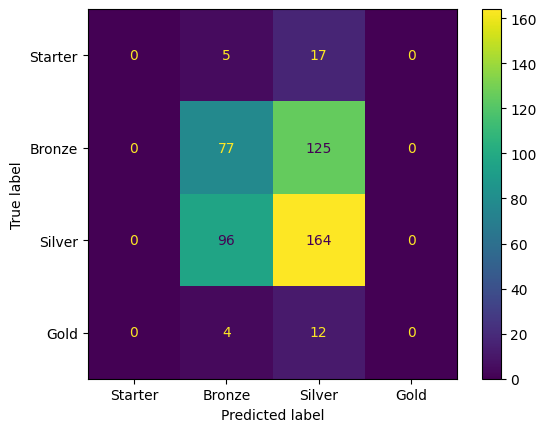

In [51]:
# Mostrar Matriz de Confusão
cm = confusion_matrix(y, y_pred, labels=lista_ordenada_target)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lista_ordenada_target)
disp.plot()

Percebemos pela matrix de confusão que o modelo não esta tendo uma acuracia boa. 

## Tuning de Hiperparametros

In [52]:
# No caso desse modelo de arvore vamos ajustar alguns hiperparâmetros usando optuna
# O primeiro parametro é o número de folhas min_samples_leaf = Mínimo de instâncias para formar uma folha (nó final)
# O segundo parametro é a profundidade max_depth = Profundidade máxima da árvore de decisão. 

def decision_tree_optuna(trial):
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_depth = trial.suggest_int('max_depth', 2, 8)

    # Ajustar o modelo do pipeline com os hiperparâmetros
    dt_model.set_params(classifier__min_samples_leaf=min_samples_leaf)
    dt_model.set_params(classifier__max_depth=max_depth)
    # Calcular a acurácia usando cross-validation
    scores = cross_val_score(dt_model, X, y, cv=cv_folds, scoring='accuracy')
    return scores.mean()
    

In [ ]:
# Executar a automação de hiperparâmetros
# Estudo com a direção de maximizar a acurácia. 
# Acuracia por que estamos retornando do decision_tree_optuna
study = optuna.create_study(direction='maximize')
study.optimize(decision_tree_optuna, n_trials=200)

In [56]:
# Mostar os resultados do estudo de otimização
print(f'Melhor Acurácia: {study.best_value:.5f}')
print(f'Melhores Parâmetros: {study.best_params}')

Melhor Acurácia: 0.51400
Melhores Parâmetros: {'min_samples_leaf': 13, 'max_depth': 3}


### Visualizar Árvore

In [57]:
# Preparar o conjunto de dados para treinar e conseguir visualizar a árvore de decisão
X_train_tree = X.copy()
X_train_tree['localizacao_label'] = X_train_tree['localizacao'].astype('category').cat.codes
X_train_tree['atividade_economica_label'] = X_train_tree['atividade_economica'].astype('category').cat.codes
X_train_tree.drop(['localizacao', 'atividade_economica'], axis=1, inplace=True)
X_train_tree.rename(columns={'localizacao_label': 'localizacao', 'atividade_economica_label': 'atividade_economica'}, inplace=True)
X_train_tree.head(10)

,faturamento_mensal,numero_de_funcionarios,idade,inovacao,localizacao,atividade_economica
0,713109.95,12,6,1,1,1
1,790714.38,9,15,0,2,1
2,1197239.33,17,4,9,2,1
3,449185.78,15,6,0,2,2
4,1006373.16,15,15,8,2,0
5,1629562.41,16,11,4,1,3
6,771179.95,13,0,1,3,3
7,707837.61,16,10,6,2,3
8,888983.66,17,10,1,0,1
9,1098512.64,13,9,3,1,2


In [58]:
# Treinar o modelo com os melhores hiperparâmetros
cfl_decision_tree = DecisionTreeClassifier(
    min_samples_leaf=study.best_params['min_samples_leaf'], 
    max_depth=study.best_params['max_depth']
)

y_train = y.copy()
clf_decision_tree = cfl_decision_tree.fit(X_train_tree, y_train)

In [60]:
# Visualizar a árvore de decisão
fig, axes = plt.subplots(figsize=(20, 20), dpi=600, nrows=1, ncols=1)

plot_tree(
    clf_decision_tree, 
    filled=True, 
    feature_names=X_train_tree.columns.to_numpy(), 
    class_names=lista_ordenada_target,
)

[Text(0.4230769230769231, 0.875, 'inovacao <= 2.5\ngini = 0.563\nsamples = 500\nvalue = [202, 16, 260, 22]\nclass = Silver'),
 Text(0.15384615384615385, 0.625, 'faturamento_mensal <= 425959.422\ngini = 0.482\nsamples = 165\nvalue = [112, 0, 35, 18]\nclass = Starter'),
 Text(0.07692307692307693, 0.375, 'gini = 0.26\nsamples = 13\nvalue = [2, 0, 0, 11]\nclass = Gold'),
 Text(0.23076923076923078, 0.375, 'faturamento_mensal <= 914181.812\ngini = 0.421\nsamples = 152\nvalue = [110, 0, 35, 7]\nclass = Starter'),
 Text(0.15384615384615385, 0.125, 'gini = 0.319\nsamples = 59\nvalue = [48, 0, 4, 7]\nclass = Starter'),
 Text(0.3076923076923077, 0.125, 'gini = 0.444\nsamples = 93\nvalue = [62, 0, 31, 0]\nclass = Starter'),
 Text(0.6923076923076923, 0.625, 'faturamento_mensal <= 549601.438\ngini = 0.474\nsamples = 335\nvalue = [90.0, 16.0, 225.0, 4.0]\nclass = Silver'),
 Text(0.5384615384615384, 0.375, 'faturamento_mensal <= 319870.688\ngini = 0.459\nsamples = 37\nvalue = [26, 0, 7, 4]\nclass = St

## Salvar o Modelo

In [61]:
import joblib

# Criar um pipeline tunado
dt_model_tunado = Pipeline(steps=[
    ('pre_processador', pre_processador),
    ('classifier', DecisionTreeClassifier(
        min_samples_leaf=study.best_params['min_samples_leaf'], 
        max_depth=study.best_params['max_depth']
    ))
])

# Treinar o modelo com todos os dados
dt_model_tunado.fit(X, y)

# Salvar o modelo
joblib.dump(dt_model_tunado, './dt_model.pkl')

['./dt_model.pkl']